# Sistemas de recomendación con LightFM
En este notebook se obtienen los distintos tipos de modelos (colaborativo, basado en contenido e híbrido) con el conjunto de datos de MovieLens y la librería LightFM.

In [38]:
# Importar todo lo necesario
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
from lightfm import LightFM
from lightfm.evaluation import precision_at_k
from lightfm.data import Dataset

import multiprocessing

## Recomendaciones

In [2]:
# Pequeña función para ver las recomendaciones
def sample_recommendation(model, data, user_ids, items_df):
    n_users, n_items = data.shape

    for user_id in user_ids:
        known_positives = items_df['Título'][data.tocsr()[user_id].indices]
        scores = model.predict(user_id, np.arange(n_items))
        top_items = items_df['Título'][np.argsort(-scores)]
        
        print("User %s" % user_id)
        print("    Known positives:")
        
        for x in known_positives[:3]:
            print("        %s" % x)
            
        print("    Recommended:")
        
        for x in top_items[:3]:
            print("         %s" % x)

In [3]:
# Pequeña función para ver las recomendaciones
def sample_recommendation_lastfm(model, data, user_ids, items_df):
    n_users, n_items = data.shape

    for user_id in user_ids:
        known_positives = items_df['Nombre'][data.tocsr()[user_id].indices]
        scores = model.predict(user_id, np.arange(n_items))
        top_items = items_df['Nombre'][np.argsort(-scores)]
        
        print("User %s" % user_id)
        print("    Known positives:")
        
        for x in known_positives[:3]:
            print("        %s" % x)
            
        print("    Recommended:")
        
        for x in top_items[:3]:
            print("         %s" % x)

## MovieLens

### Obtención de los dataframes

In [4]:
# Obtención del dataframe de datos
ml_data_df = pd.read_csv('data/movielens/ml_data.csv', delim_whitespace=True, names=['Id Usuario','Id Película','Valoración','Fecha'])

# Descomentar para comprobar que el dataframe se ha obtenido correctamente
#ml_data_df

# Obtención del dataframe de usuarios
ml_users_df = pd.read_csv('data/movielens/user.csv', sep='|', names=['Id Usuario', 'Edad', 'Género', 'Ocupación', 'Código Postal'])

# Descomentar para comprobar que el dataframe se ha obtenido correctamente
#ml_users_df

# Obtención del dataframe de items
ml_items_df = pd.read_csv('data/movielens/ml_items.csv', sep='|',
    names=['Id Película','Título','Fecha de estreno','Fecha DVD','iMDB','Género desconocido','Acción','Aventura','Animación','Infantil','Comedia', 'Crimen','Docuemntal','Drama','Fantasía','Cine negro','Horror','Musical','Misterio','Romance','Ciencia ficción','Thriller','Bélico','Western'],
    encoding='latin-1')

# Descomentar para comprobar que el dataframe se ha obtenido correctamente
#ml_items_df

### Obtención del dataset y de las matrices   
Convierto los dataframes en las estructuras de datos que necesita LightFM para poder sacar las matrices y poder hacer uso de su sistema de recomendación

In [5]:
# Obtención de los dataset
ml_dataset = Dataset()
ml_dataset.fit(ml_data_df['Id Usuario'], ml_data_df['Id Película'])
ml_dataset.fit_partial(users=ml_users_df['Id Usuario'], items=ml_items_df['Id Película'],
                    user_features=ml_users_df['Género'], item_features=ml_items_df['Título'])

#num_users, num_items = ml_dataset.interactions_shape()
#print('Num users: {}, num_items {}.'.format(num_users, num_items))

# Obtención de las matrices
(ml_interactions, ml_weights) = ml_dataset.build_interactions((row['Id Usuario'], row['Id Película'], row['Valoración']) for index, row in ml_data_df.iterrows())
ml_item_features = ml_dataset.build_item_features((row['Id Película'], [row['Título']]) for index, row in ml_items_df.iterrows())
ml_user_features = ml_dataset.build_user_features((row['Id Usuario'], [row['Género']]) for index, row in ml_users_df.iterrows())

### Obtención de los modelos

#### Modelo colaborativo

In [6]:
ml_collab_model = LightFM(loss='warp')
ml_collab_model.fit(ml_interactions, sample_weight=ml_weights, epochs=30, num_threads=multiprocessing.cpu_count())

In [7]:
sample_recommendation(ml_collab_model, ml_interactions, [3, 25, 450], ml_items_df)

User 3
    Known positives:
        Get Shorty (1995)
        Twelve Monkeys (1995)
        Dead Man Walking (1995)
    Recommended:
         Pinocchio (1940)
         Birdcage, The (1996)
         Searching for Bobby Fischer (1993)
User 25
    Known positives:
        Babe (1995)
        Dead Man Walking (1995)
        Seven (Se7en) (1995)
    Recommended:
         My Life as a Dog (Mitt liv som hund) (1985)
         Natural Born Killers (1994)
         Ace Ventura: When Nature Calls (1995)
User 450
    Known positives:
        Twelve Monkeys (1995)
        Babe (1995)
        Seven (Se7en) (1995)
    Recommended:
         Free Willy (1993)
         Spawn (1997)
         Star Wars (1977)


#### Modelo híbrido

In [8]:
ml_hybrid_model = LightFM(loss='warp')
ml_hybrid_model.fit(ml_interactions, item_features=ml_item_features, sample_weight=ml_weights, epochs=30, num_threads=multiprocessing.cpu_count())

In [9]:
sample_recommendation(ml_hybrid_model, ml_interactions, [3, 25, 450], ml_items_df)

User 3
    Known positives:
        Get Shorty (1995)
        Twelve Monkeys (1995)
        Dead Man Walking (1995)
    Recommended:
         Birdcage, The (1996)
         Grosse Pointe Blank (1997)
         Pinocchio (1940)
User 25
    Known positives:
        Babe (1995)
        Dead Man Walking (1995)
        Seven (Se7en) (1995)
    Recommended:
         Young Guns (1988)
         My Life as a Dog (Mitt liv som hund) (1985)
         On Golden Pond (1981)
User 450
    Known positives:
        Twelve Monkeys (1995)
        Babe (1995)
        Seven (Se7en) (1995)
    Recommended:
         Spawn (1997)
         Free Willy (1993)
         Raging Bull (1980)


#### Modelo por contenido

In [10]:
ml_content_model = LightFM(loss='warp')
ml_content_model.fit(ml_interactions, user_features=ml_user_features, item_features=ml_item_features, sample_weight=ml_weights, epochs=30, num_threads=multiprocessing.cpu_count())

In [11]:
sample_recommendation(ml_content_model, ml_interactions, [3, 25, 450], ml_items_df)

User 3
    Known positives:
        Get Shorty (1995)
        Twelve Monkeys (1995)
        Dead Man Walking (1995)
    Recommended:
         My Life as a Dog (Mitt liv som hund) (1985)
         Liar Liar (1997)
         Rainmaker, The (1997)
User 25
    Known positives:
        Babe (1995)
        Dead Man Walking (1995)
        Seven (Se7en) (1995)
    Recommended:
         Ulee's Gold (1997)
         Little Women (1994)
         Gay Divorcee, The (1934)
User 450
    Known positives:
        Twelve Monkeys (1995)
        Babe (1995)
        Seven (Se7en) (1995)
    Recommended:
         Free Willy (1993)
         Spawn (1997)
         Robert A. Heinlein's The Puppet Masters (1994)


## Anime

### Obtención de los dataframes

In [5]:
# Obtención del dataframe de items
anime_items_df = pd.read_csv('data/anime/anime.csv', sep=',', 
    names=['Id Anime', 'Título', 'Género', 'Tipo', 'Episodios', 'Valoración Media', 'Miembros'])

# Descomentar para comprobar que el dataframe se ha obtenido correctamente
#anime_items_df

# Obtención del dataframe de datos
anime_data1_df = pd.read_csv('data/anime/ratings1.csv', sep=',', names=['Id Usuario', 'Id Anime', 'Valoración'], low_memory=False)
anime_data2_df = pd.read_csv('data/anime/ratings2.csv', sep=',', names=['Id Usuario', 'Id Anime', 'Valoración'], low_memory=False)
anime_data3_df = pd.read_csv('data/anime/ratings3.csv', sep=',', names=['Id Usuario', 'Id Anime', 'Valoración'], low_memory=False)
anime_data4_df = pd.read_csv('data/anime/ratings4.csv', sep=',', names=['Id Usuario', 'Id Anime', 'Valoración'], low_memory=False)
anime_data_df = pd.concat([anime_data1_df, anime_data2_df, anime_data3_df, anime_data4_df])

# Descomentar para comprobar que el dataframe se ha obtenido correctamente
#anime_data_df

### Obtención del dataset y de las matrices  
Convierto los dataframes en las estructuras de datos que necesita LightFM para poder sacar las matrices y poder hacer uso de su sistema de recomendación

In [41]:
# Obtención de los dataset
anime_dataset = Dataset()
anime_dataset.fit(anime_data_df['Id Usuario'], anime_data_df['Id Anime'])
anime_dataset.fit_partial(items=anime_items_df['Id Anime'], item_features=anime_items_df['Título'])

#num_users, num_items = anime_dataset.interactions_shape()
#print('Num users: {}, num_items {}.'.format(num_users, num_items))

# Obtención de las matrices
(anime_interactions, anime_weights) = anime_dataset.build_interactions((row['Id Usuario'], row['Id Anime'], row['Valoración']) for index, row in anime_data_df.iterrows())
anime_item_features = anime_dataset.build_item_features((row['Id Anime'], [row['Título']]) for index, row in anime_items_df.iterrows())

### Obtención de los modelos

#### Modelo colaborativo

In [42]:
anime_collab_model = LightFM(loss='warp')
anime_collab_model.fit(anime_interactions, sample_weight=anime_weights, epochs=30, num_threads=multiprocessing.cpu_count())

In [43]:
sample_recommendation(anime_collab_model, anime_interactions, [3, 25, 450], anime_items_df)

User 3
    Known positives:
        Steins;Gate
        Sen to Chihiro no Kamikakushi
        Ookami Kodomo no Ame to Yuki
    Recommended:
         Lina Poe Poe
         Katta-kun Monogatari
         Master of Torque 3
User 25
    Known positives:
        Ookami Kodomo no Ame to Yuki
        Monogatari Series: Second Season
        Fate/Zero 2nd Season
    Recommended:
         Lina Poe Poe
         Katta-kun Monogatari
         Master of Torque 3
User 450
    Known positives:
        Kimi no Na wa.
        Fullmetal Alchemist: Brotherhood
        Ginga Eiyuu Densetsu
    Recommended:
         Gintama: Shiroyasha Koutan
         Rose of Versailles
         Mitsudomoe Zouryouchuu!


#### Modelo híbrido

In [44]:
anime_hybrid_model = LightFM(loss='warp')
# Comentar la línea que no proceda
anime_hybrid_model.fit(anime_interactions, item_features=anime_item_features, sample_weight=anime_weights, epochs=30, num_threads=multiprocessing.cpu_count())

In [45]:
sample_recommendation(anime_hybrid_model, anime_interactions, [3, 25, 450], anime_items_df)

User 3
    Known positives:
        Steins;Gate
        Sen to Chihiro no Kamikakushi
        Ookami Kodomo no Ame to Yuki
    Recommended:
         Mirai Kara no Message
         Geunyeoneun Yeppeotda
         Xi You Ji
User 25
    Known positives:
        Ookami Kodomo no Ame to Yuki
        Monogatari Series: Second Season
        Fate/Zero 2nd Season
    Recommended:
         Mirai Kara no Message
         Geunyeoneun Yeppeotda
         Xi You Ji
User 450
    Known positives:
        Kimi no Na wa.
        Fullmetal Alchemist: Brotherhood
        Ginga Eiyuu Densetsu
    Recommended:
         Gintama: Shiroyasha Koutan
         Cardcaptor Sakura Movie 2: Fuuin Sareta Card
         Rose of Versailles


## Book-Crossing

### Obtención de los dataframes

In [6]:
# Obtención del dataframe de datos
bc_data_df = pd.read_csv('data/book-crossing/BX-Book-Ratings.csv', sep=';', names=['Id Usuario','ISBN','Valoración'], encoding='cp1252', low_memory=False)

# Descomentar para comprobar que el dataframe se ha obtenido correctamente
#bc_data_df

# Obtención del dataframe de usuarios
bc_users_df = pd.read_csv('data/book-crossing/BX-Users.csv', sep=';', names=['Id Usuario', 'Residencia', 'Edad'], encoding='cp1252')
bc_users_df = bc_users_df.fillna(0)

# Descomentar para comprobar que el dataframe se ha obtenido correctamente
#bc_users_df

# Obtención del dataframe de items
bc_items_df = pd.read_csv('data/book-crossing/BX-Books.csv', sep=';', names=['ISBN','Título','Autor','Fecha de publicación','Editorial','URL S','URL M','URL L'], encoding='cp1252', low_memory=False)

# Descomentar para comprobar que el dataframe se ha obtenido correctamente
#bc_items_df

### Obtención del dataset y de las matrices  
Convierto los dataframes en las estructuras de datos que necesita LightFM para poder sacar las matrices y poder hacer uso de su sistema de recomendación

In [30]:
# Obtención de los dataset
bc_dataset = Dataset()
bc_dataset.fit(bc_data_df['Id Usuario'], bc_data_df['ISBN'])
bc_dataset.fit_partial(users=bc_users_df['Id Usuario'], items=bc_items_df['ISBN'],
                    user_features=bc_users_df['Edad'], item_features=bc_items_df['Título'])

#num_users, num_items = bc_dataset.interactions_shape()
#print('Num users: {}, num_items {}.'.format(num_users, num_items))

# Obtención de las matrices
(bc_interactions, bc_weights) = bc_dataset.build_interactions((row['Id Usuario'], row['ISBN'], row['Valoración']) for index, row in bc_data_df.iterrows())
bc_item_features = bc_dataset.build_item_features((row['ISBN'], [row['Título']]) for index, row in bc_items_df.iterrows())
bc_user_features = bc_dataset.build_user_features((row['Id Usuario'], [row['Edad']]) for index, row in bc_users_df.iterrows())

### Obtención de los modelos

#### Modelo colaborativo

In [31]:
bc_collab_model = LightFM(loss='warp')
bc_collab_model.fit(bc_interactions, sample_weight=bc_weights, epochs=30, num_threads=multiprocessing.cpu_count())

In [32]:
sample_recommendation(bc_collab_model, bc_interactions, [3, 25, 450], bc_items_df)

User 3
    Known positives:
        Flu: The Story of the Great Influenza Pandemic of 1918 and the Search for the Virus That Caused It
        The Mummies of Urumchi
    Recommended:
         Way Beyond Therapy (Peanuts at Work and Play)
         Murder in the Cathedral (A Harvest/Hbj Book)
         Portrait Du Joueur
User 25
    Known positives:
        Flood : Mississippi 1927
        The Right Man : The Surprise Presidency of George W. Bush
        Daybreakers Louis Lamour Collection
    Recommended:
         Bridget Jones : The Edge of Reason
         Crewel Lye
         Fast Women
User 450
    Known positives:
        The Deed of Paksenarrion
    Recommended:
         Crewel Lye
         Mawrdew Czgowchwz (New York Review Books Classics)
         The Four Agreements: A Practical Guide to Personal Freedom


#### Modelo híbrido

In [33]:
bc_hybrid_model = LightFM(loss='warp')
bc_hybrid_model.fit(bc_interactions, item_features=bc_item_features, sample_weight=bc_weights, epochs=30, num_threads=multiprocessing.cpu_count())

In [34]:
sample_recommendation(bc_hybrid_model, bc_interactions, [3, 25, 450], bc_items_df)

User 3
    Known positives:
        Flu: The Story of the Great Influenza Pandemic of 1918 and the Search for the Virus That Caused It
        The Mummies of Urumchi
    Recommended:
         Secret Door to Success
         No Place Like Home
         Five Have a Mystery to Solve
User 25
    Known positives:
        Flood : Mississippi 1927
        The Right Man : The Surprise Presidency of George W. Bush
        Daybreakers Louis Lamour Collection
    Recommended:
         Crewel Lye
         I Rant Therefore I Am
         Decipher
User 450
    Known positives:
        The Deed of Paksenarrion
    Recommended:
         Crewel Lye
         Mawrdew Czgowchwz (New York Review Books Classics)
         The Four Agreements: A Practical Guide to Personal Freedom


#### Modelo por contenido

In [35]:
bc_content_model = LightFM(loss='warp')
bc_content_model.fit(bc_interactions, user_features=bc_user_features, item_features=bc_item_features, sample_weight=bc_weights, epochs=30, num_threads=multiprocessing.cpu_count())

In [36]:
sample_recommendation(bc_content_model, bc_interactions, [3, 25, 450], bc_items_df)

User 3
    Known positives:
        Flu: The Story of the Great Influenza Pandemic of 1918 and the Search for the Virus That Caused It
        The Mummies of Urumchi
    Recommended:
         MCSE : Networking Essentials Study Guide
         Scooby-Doo and the Phantom Cowboy (Scooby-Doo, 3)
         The Singing Tree (Puffin Newbery Library)
User 25
    Known positives:
        Flood : Mississippi 1927
        The Right Man : The Surprise Presidency of George W. Bush
        Daybreakers Louis Lamour Collection
    Recommended:
         The Four Agreements: A Practical Guide to Personal Freedom
         Crewel Lye
         Angels and Bolters: Women's Cancer Scripts
User 450
    Known positives:
        The Deed of Paksenarrion
    Recommended:
         Crewel Lye
         The Four Agreements: A Practical Guide to Personal Freedom
         Rainbow the Stormy Life of Judy Garland


## LastFM

### Obtención de los dataframes

In [7]:
# Obtención del dataframe de datos
lf_data_df = pd.read_csv('data/lastfm/user_artists.csv', sep='\t', names=['Id Usuario','Id Artista','Veces escuchado'])

# Descomentar para comprobar que el dataframe se ha obtenido correctamente
#lf_data_df

# Obtención del dataframe de usuarios
lf_users_df = pd.read_csv('data/lastfm/user_friends.csv', sep='\t', names=['Id Usuario', 'Id Amigo'])

# Descomentar para comprobar que el dataframe se ha obtenido correctamente
#lf_users_df

# Obtención del dataframe de items
lf_artists_df = pd.read_csv('data/lastfm/artists.csv', sep='\t', names=['Id Artista','Nombre','URL','URL Foto'])
lf_artists_df = lf_artists_df.drop(['URL', 'URL Foto'], axis=1)
lf_generos_df = pd.read_csv('data/lastfm/user_taggedartists-timestamps.csv', sep='\t', names=['Id Usuario','Id Artista','Id Genero','Timestamp'])
lf_generos_df = lf_generos_df.drop(['Id Usuario', 'Timestamp'], axis=1)
lf_items_df = lf_artists_df.merge(lf_generos_df, left_on='Id Artista', right_on='Id Artista') 

# Descomentar para comprobar que el dataframe se ha obtenido correctamente
#lf_items_df

### Obtención del dataset y de las matrices

In [38]:
# Obtención de los dataset
lf_dataset = Dataset()
lf_dataset.fit(lf_data_df['Id Usuario'], lf_data_df['Id Artista'])
lf_dataset.fit_partial(users=lf_users_df['Id Usuario'], items=lf_items_df['Id Artista'],
                    user_features=lf_users_df['Id Amigo'], item_features=lf_items_df['Nombre'])

#num_users, num_items = lf_dataset.interactions_shape()
#print('Num users: {}, num_items {}.'.format(num_users, num_items))

# Obtención de las matrices
(lf_interactions, lf_weights) = lf_dataset.build_interactions((row['Id Usuario'], row['Id Artista'], row['Veces escuchado']) for index, row in lf_data_df.iterrows())
lf_item_features = lf_dataset.build_item_features((row['Id Artista'], [row['Nombre']]) for index, row in lf_items_df.iterrows())
lf_user_features = lf_dataset.build_user_features((row['Id Usuario'], [row['Id Amigo']]) for index, row in lf_users_df.iterrows())

### Obtención de los modelos

#### Modelo colaborativo

In [39]:
lf_collab_model = LightFM(loss='warp')
lf_collab_model.fit(lf_interactions, sample_weight=lf_weights, epochs=30, num_threads=multiprocessing.cpu_count())

In [15]:
sample_recommendation_lastfm(lf_collab_model, lf_interactions, [3, 25, 450], lf_items_df)

User 3
    Known positives:
        MALICE MIZER
        Moonspell
        Marilyn Manson
    Recommended:
         Moonspell
         Marilyn Manson
         Grendel
User 25
    Known positives:
        MALICE MIZER
        MALICE MIZER
        MALICE MIZER
    Recommended:
         MALICE MIZER
         Sopor Aeternus & The Ensemble of Shadows
         Sopor Aeternus & The Ensemble of Shadows
User 450
    Known positives:
        MALICE MIZER
        MALICE MIZER
        Diary of Dreams
    Recommended:
         Diary of Dreams
         Diary of Dreams
         MALICE MIZER


#### Modelo híbrido

In [16]:
lf_hybrid_model = LightFM(loss='warp')
lf_hybrid_model.fit(lf_interactions, item_features=lf_item_features, sample_weight=lf_weights, epochs=30, num_threads=multiprocessing.cpu_count())

In [17]:
sample_recommendation_lastfm(lf_hybrid_model, lf_interactions, [3, 25, 450], lf_items_df)

User 3
    Known positives:
        MALICE MIZER
        Moonspell
        Marilyn Manson
    Recommended:
         Goldfrapp
         Coldplay
         Goldfrapp
User 25
    Known positives:
        MALICE MIZER
        MALICE MIZER
        MALICE MIZER
    Recommended:
         Gorillaz
         New Order
         Gorillaz
User 450
    Known positives:
        MALICE MIZER
        MALICE MIZER
        Diary of Dreams
    Recommended:
         Depeche Mode
         Air
         Duran Duran


#### Modelo por contenido

In [18]:
lf_content_model = LightFM(loss='warp')
lf_content_model.fit(lf_interactions, user_features=lf_user_features, item_features=lf_item_features, sample_weight=lf_weights, epochs=30, num_threads=multiprocessing.cpu_count())

In [19]:
sample_recommendation_lastfm(lf_content_model, lf_interactions, [3, 25, 450], lf_items_df)

User 3
    Known positives:
        MALICE MIZER
        Moonspell
        Marilyn Manson
    Recommended:
         Marilyn Manson
         Kylie Minogue
         Kylie Minogue
User 25
    Known positives:
        MALICE MIZER
        MALICE MIZER
        MALICE MIZER
    Recommended:
         Hooverphonic
         Faithless
         Kylie Minogue
User 450
    Known positives:
        MALICE MIZER
        MALICE MIZER
        Diary of Dreams
    Recommended:
         Coldplay
         Behemoth
         Air


## Visualización de los conjuntos de datos

### Obtención de los tados

In [42]:
n_users_ml = len(ml_data_df['Id Usuario'].unique())
n_items_ml = len(ml_data_df['Id Película'].unique())
n_ratings_ml = ml_data_df['Valoración'].count()
ratings_per_user_ml = round(n_ratings_ml / n_users_ml)

n_users_anime = len(anime_data_df['Id Usuario'].unique())
n_items_anime = len(anime_data_df['Id Anime'].unique())
n_ratings_anime = anime_data_df['Valoración'].count()
ratings_per_user_anime = round(n_ratings_anime / n_users_anime)

n_users_bc = len(bc_data_df['Id Usuario'].unique())
n_items_bc = len(bc_data_df['ISBN'].unique())
n_ratings_bc = bc_data_df['Valoración'].count()
ratings_per_user_bc = round(n_ratings_bc / n_users_bc)

n_users_lf = len(lf_data_df['Id Usuario'].unique())
n_items_lf = len(lf_data_df['Id Artista'].unique())
n_ratings_lf = lf_data_df['Veces escuchado'].count()
ratings_per_user_lf = round(n_ratings_lf / n_users_lf)

users = [n_users_ml, n_users_anime, n_users_bc, n_users_lf]
items = [n_items_ml, n_items_anime, n_items_bc, n_items_lf]
ratings = [ratings_per_user_ml, ratings_per_user_anime, ratings_per_user_bc, ratings_per_user_lf]

### Obtención de los gráficos

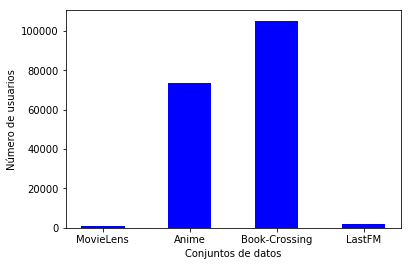

In [76]:
X = np.arange(4)
plt.bar(X, users, color="b", width=0.50)
plt.xticks(X, ["MovieLens", "Anime", "Book-Crossing", "LastFM"])
plt.xlabel("Conjuntos de datos")
plt.ylabel("Número de usuarios")
plt.show()

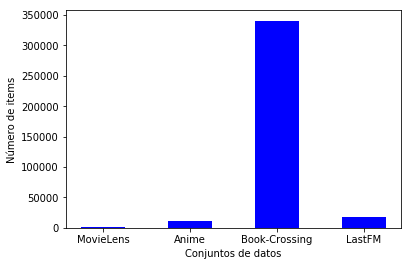

In [77]:
plt.bar(X, items, color="b", width=0.50)
plt.xticks(X, ["MovieLens", "Anime", "Book-Crossing", "LastFM"])
plt.xlabel("Conjuntos de datos")
plt.ylabel("Número de items")
plt.show()

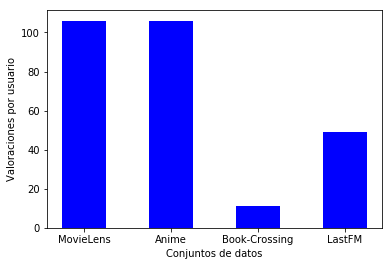

In [75]:
plt.bar(X, ratings, color="b", width=0.50)
plt.xticks(X, ["MovieLens", "Anime", "Book-Crossing", "LastFM"])
plt.xlabel("Conjuntos de datos")
plt.ylabel("Valoraciones por usuario")
plt.show()

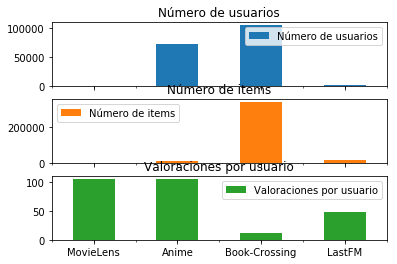

In [74]:
graficos_df = pd.DataFrame({'Número de usuarios':users, 'Número de items':items, 'Valoraciones por usuario':ratings},
                          index=['MovieLens', 'Anime', 'Book-Crossing', 'LastFM'])

grafica = graficos_df.plot.bar(rot=0, subplots=True)